In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt


In [12]:
torch.manual_seed(42)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device is {device}')

Device is cuda


In [14]:
df = pd.read_csv('/content/fashion.csv')
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0,0,0,0,0,0,1,1,1,0,...,0,15,3,0,20,0,0,0,0,2
1,0,0,0,0,0,0,1,0,0,15,...,167,134,0,16,180,160,16,0,0,2
2,0,0,0,0,0,0,0,0,1,0,...,0,0,105,99,80,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,60,...,0,0,0,53,108,95,21,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,119,148,83,0,0,0,0,2


In [15]:
df.shape

(60000, 785)

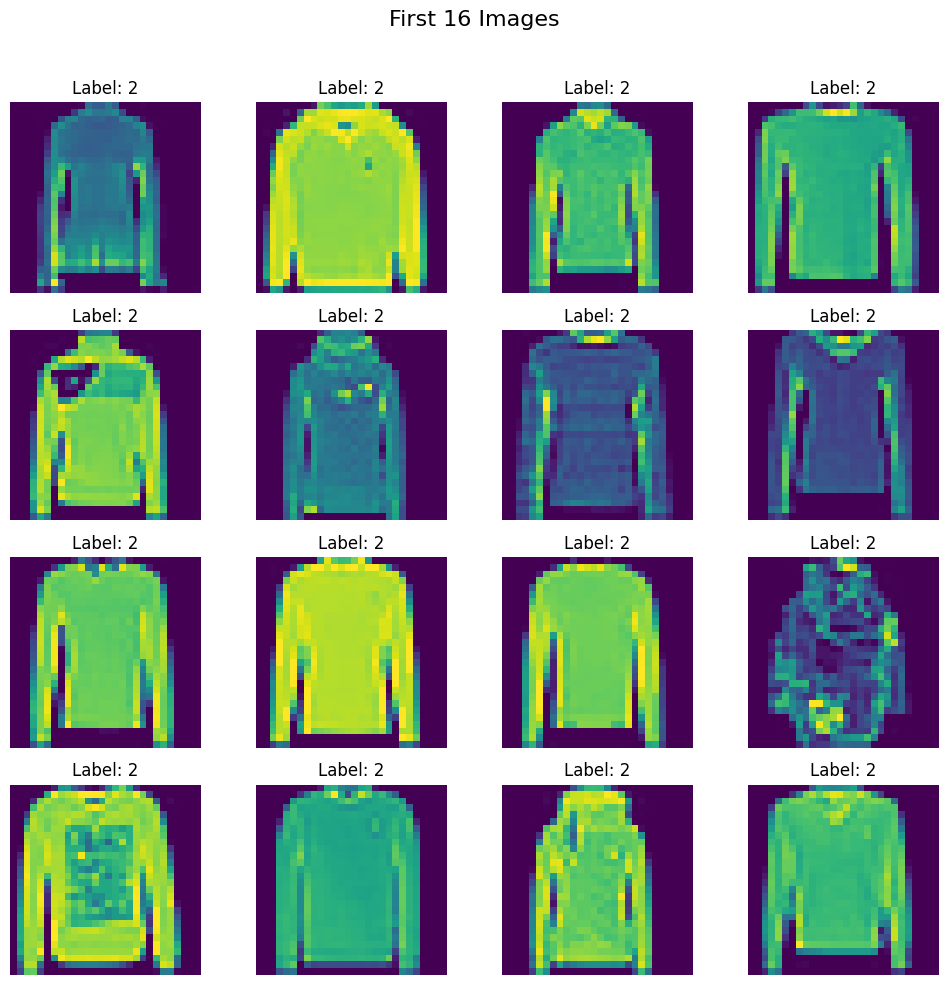

In [16]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, -1]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [17]:
# train test split

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [22]:
train_dataset = CustomDataset(X_train, y_train)

In [23]:
test_dataset = CustomDataset(X_test, y_test)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [28]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features_extra = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features_extra(x)
        x = self.classifier(x)

        return x

In [29]:
learning_rate = 0.01
epochs = 100

In [30]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [31]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6453165261844794
Epoch: 2 , Loss: 0.38421513320008915
Epoch: 3 , Loss: 0.32321457854906716
Epoch: 4 , Loss: 0.28682179245352746
Epoch: 5 , Loss: 0.2606672980065147
Epoch: 6 , Loss: 0.23874975823114317
Epoch: 7 , Loss: 0.2221804552624623
Epoch: 8 , Loss: 0.20730734161101283
Epoch: 9 , Loss: 0.19218388940704365
Epoch: 10 , Loss: 0.18201369134398798
Epoch: 11 , Loss: 0.16943569422264892
Epoch: 12 , Loss: 0.1641768899820745
Epoch: 13 , Loss: 0.1520301386701564
Epoch: 14 , Loss: 0.14060580448651067
Epoch: 15 , Loss: 0.13637914212901767
Epoch: 16 , Loss: 0.12854483619797974
Epoch: 17 , Loss: 0.12071244503216197
Epoch: 18 , Loss: 0.11317497554933652
Epoch: 19 , Loss: 0.11029914358413467
Epoch: 20 , Loss: 0.1027574575622178
Epoch: 21 , Loss: 0.09951530733914114
Epoch: 22 , Loss: 0.09530732861134068
Epoch: 23 , Loss: 0.09106286956431965
Epoch: 24 , Loss: 0.08169381632756752
Epoch: 25 , Loss: 0.08033424879408751
Epoch: 26 , Loss: 0.07715714345499873
Epoch: 27 , Loss: 0.0746627

In [32]:
model.eval()

MyNN(
  (features_extra): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [33]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9228333333333333


In [34]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9998333333333334
